In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# **[Q2] Simple Multinomial Processing Trees (MPTs) [10 pts]**

Collect some data (e.g., from a friend or your teammate) on the recognition memory task from the slides (or construct your own task) and fit the following two models using `Stan`:
- The One-High-Threshold Model (1HT)
- The Two-High-Threshold Model (2HT)

The models are depicted on Slide 12 of MPT models (Week 10). As usual, inspect the convergence of the MCMC samplers and report the estimation results. Do the two models suggest different estimates for the two key parameters? Describe and interpret the results.

*(image from Slide 12 of MPT models (Week 10))*
<br><img src="Q2_basic_threshold_models_fig.png" width=70% height=70% />

**Conditional:** "Which of the following words were present in the *old* list?"
| Actual \ Prediction | predicted Old (PP) | predicted New (PN) |
| --- | --- | --- |
| actually in Old list (P) | 9 (TP) | 1 (FN) |
| actually only in New list (N) | 3 (FP) | 7 (TN) |

In [2]:
# Data collected on Recognition Memory Task [MPT slides - Week 10, S10-S11]
# 20 words, 1 subject
# - 9 correctly put as "Old" (True Positive)
# - 1 incorreclty put as "Old", when they were only in the "New" list (False Negative)
# - 7 correctly put as "New" (True Negative)
# - 3 incorrectly put as "New", when they were also in the "Old" list (False Positive)

N_num_trials = 20 # 20 words
data = np.array([9, 1, 7, 3]) # 9 TP, 1 FN, 7 TN, 3 FP

pd.DataFrame(data[None, :], columns=['TP', 'FN', 'TN', 'FP'], index=['frequencies'])

,TP,FN,TN,FP
frequencies,9,1,7,3


## **One-high-threshold (1HT) MPT model:**

<u>1HT MPT Model probability equations:</u>
- <u>TP (in Old, predict Old):</u> $\theta_1 = 0.5*\big( d + (1-d)*g \big)$
- <u>FN (in Old, predict New):</u> $\theta_2 = 0.5*\big( (1-d)*(1-g) \big)$
- <u>TN (in New, predict New):</u> $\theta_3 = 0.5*( 1-g )$
- <u>FP (in New, predict Old):</u> $\theta_4 = 0.5*( g )$

*(note: the $0.5*$ is due to assuming each word has 50/50 probability of being "Old" or "New")*

In [3]:
stan_code_1HT_MPT_model = """
data {
    int<lower=1> N; // Number of trials
    int<lower=1> K; // Number of categories
    array[K] int<lower=0, upper=N> freqs;
}

parameters {
    // d and g are probabilities, so bounds are [0,1]
    real<lower=0, upper=1> d;
    real<lower=0, upper=1> g;
}

transformed parameters {
    simplex[K] theta; // basically assuming K=4
    theta[1] = 0.5*( d + (1-d)*g ); // TP
    theta[2] = 0.5*( (1-d)*(1-g) ); // FN
    theta[3] = 0.5*( 1-g );         // TN
    theta[4] = 0.5*( g );           // FP
}

model {
    // Priors
    target += beta_lpdf(d | 1, 1);
    target += beta_lpdf(g | 1, 1);

    // Likelihood
    target += multinomial_lpmf(freqs | theta);
}

generated quantities {
    array[K] int pred_freqs = multinomial_rng(theta, N);
}
"""

In [4]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': N_num_trials,
    'K': data.shape[0]
}

# Compile model
"""Building: 19.5s, done."""
posterior_1HT = stan.build(stan_code_1HT_MPT_model, data=stan_dict, random_seed=42)

# Sample (i.e., inverse inference)
fit_1HT = posterior_1HT.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: found in cache, done.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [5]:
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit_1HT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.730,0.179,0.402,0.986,0.002,0.002,5996.0,4986.0,1.0
g,0.363,0.135,0.111,0.610,0.002,0.001,5880.0,5241.0,1.0
theta[0],0.418,0.051,0.324,0.494,0.001,0.000,7619.0,6297.0,1.0
theta[1],0.082,0.051,0.006,0.176,0.001,0.000,7619.0,6297.0,1.0
theta[2],0.319,0.067,0.195,0.444,0.001,0.001,5880.0,5241.0,1.0
theta[3],0.181,0.067,0.056,0.305,0.001,0.001,5880.0,5241.0,1.0
pred_freqs[0],8.372,2.405,3.000,12.000,0.025,0.018,9258.0,9571.0,1.0
pred_freqs[1],1.623,1.559,0.000,4.000,0.016,0.012,9130.0,9119.0,1.0
pred_freqs[2],6.369,2.473,1.000,10.000,0.027,0.019,8310.0,8843.0,1.0
pred_freqs[3],3.636,2.163,0.000,7.000,0.024,0.017,8184.0,8531.0,1.0


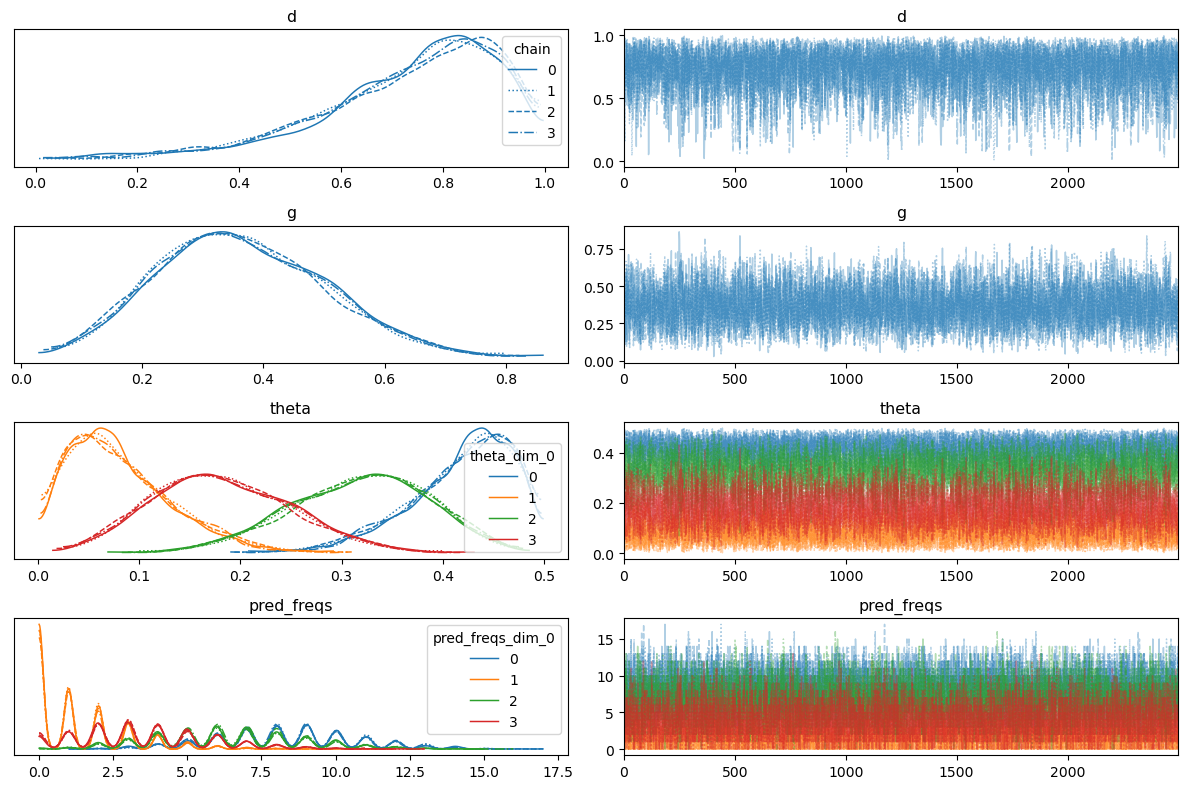

In [6]:
# Traceplots and marginals - visual convergence checks
ax_1HT = az.plot_trace(fit_1HT, legend=True)
plt.tight_layout()

## **Two-high-threshold (2HT) MPT model:**

<u>2HT MPT Model probability equations:</u>
- <u>TP (in Old, predict Old):</u> $\theta_1 = 0.5*\big( d + (1-d)*g \big)$
- <u>FN (in Old, predict New):</u> $\theta_2 = 0.5*\big( (1-d)*(1-g) \big)$
- <u>TN (in New, predict New):</u> $\theta_3 = 0.5*\big( d + (1-d)*(1-g) \big)$
- <u>FP (in New, predict Old):</u> $\theta_4 = 0.5*\big( (1-d)*g \big)$

In [7]:
stan_code_2HT_MPT_model = """
data {
    int<lower=1> N; // Number of trials
    int<lower=1> K; // Number of categories
    array[K] int<lower=0, upper=N> freqs;
}

parameters {
    // d and g are probabilities, so bounds are [0,1]
    real<lower=0, upper=1> d;
    real<lower=0, upper=1> g;
}

transformed parameters {
    simplex[K] theta; // basically assuming K=4
    theta[1] = 0.5*( d + (1-d)*g );     // TP
    theta[2] = 0.5*( (1-d)*(1-g) );     // FN
    theta[3] = 0.5*( d + (1-d)*(1-g) ); // TN
    theta[4] = 0.5*( (1-d)*g );         // FP
}

model {
    // Priors
    target += beta_lpdf(d | 1, 1);
    target += beta_lpdf(g | 1, 1);

    // Likelihood
    target += multinomial_lpmf(freqs | theta);
}

generated quantities {
    array[K] int pred_freqs = multinomial_rng(theta, N);
}
"""

In [8]:
# (Data is same as 1HT, so don't need to prepare it again)
# Compile model
"""Building: 17.6s, done."""
posterior_2HT = stan.build(stan_code_2HT_MPT_model, data=stan_dict, random_seed=42)

# Sample (i.e., inverse inference)
fit_2HT = posterior_2HT.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: found in cache, done.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


In [9]:
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit_2HT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.561,0.162,0.242,0.838,0.002,0.002,6004.0,4705.0,1.0
g,0.675,0.164,0.380,0.960,0.002,0.001,6456.0,4668.0,1.0
theta[0],0.428,0.047,0.342,0.498,0.001,0.000,5903.0,5358.0,1.0
theta[1],0.072,0.047,0.002,0.158,0.001,0.000,5903.0,5358.0,1.0
theta[2],0.353,0.063,0.230,0.458,0.001,0.001,7234.0,6308.0,1.0
theta[3],0.147,0.063,0.042,0.270,0.001,0.001,7234.0,6308.0,1.0
pred_freqs[0],8.554,2.418,3.000,12.000,0.025,0.018,9509.0,9669.0,1.0
pred_freqs[1],1.425,1.452,0.000,4.000,0.016,0.011,8100.0,8545.0,1.0
pred_freqs[2],7.074,2.477,2.000,11.000,0.026,0.018,9316.0,8966.0,1.0
pred_freqs[3],2.947,2.039,0.000,6.000,0.022,0.016,8743.0,8794.0,1.0


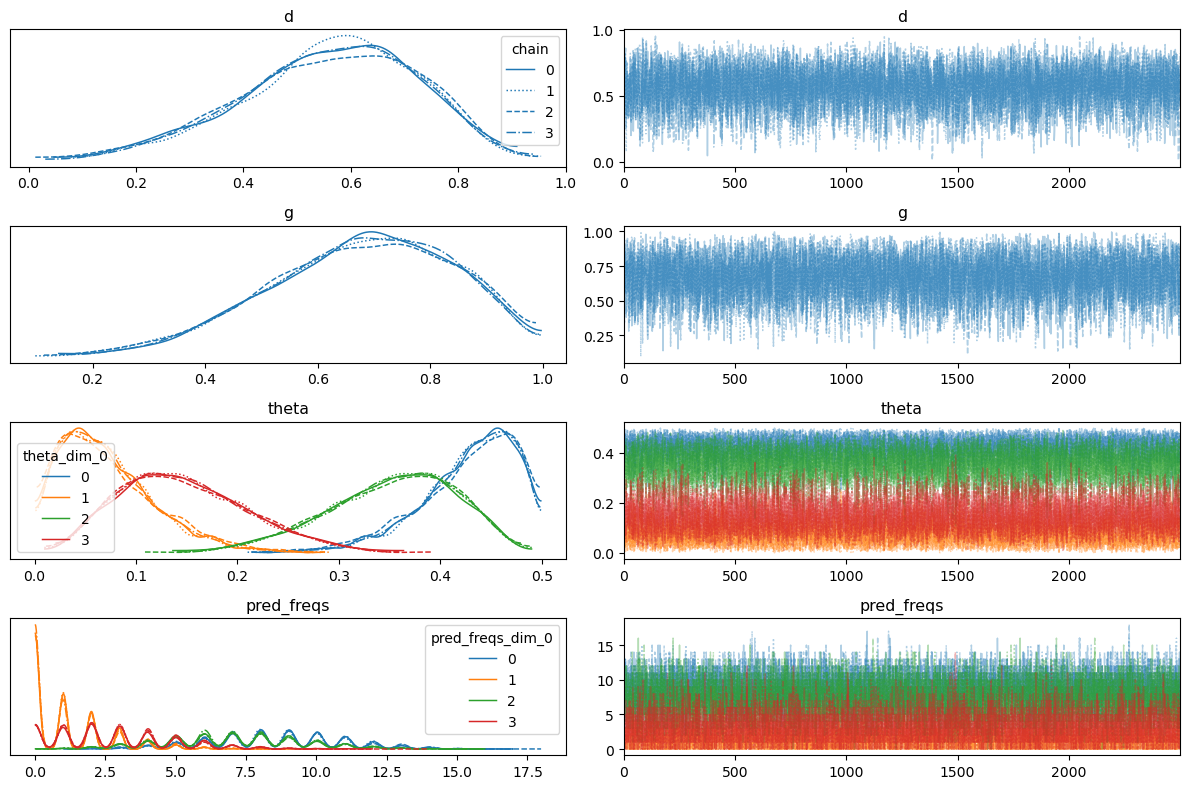

In [10]:
# Traceplots and marginals - visual convergence checks
ax_2HT = az.plot_trace(fit_2HT, legend=True)
plt.tight_layout()

## **Result Analysis**

*(As usual, inspect the convergence of the MCMC samplers and report the estimation results. Do the two models suggest different estimates for the two key parameters? Describe and interpret the results.)*

**Inspect convergence and efficiency diagnostics:**
- Convergence: Since `r_hat` equals 1.0 for each parameter in both models, this suggests that the models converged well. (want $\hat{R} < 1.05$)
- Efficiency: `ess_bulk` and `ess_tail` are both well above 100 for all parameters in both models, which suggests that the models sampled efficiently.

**The 2 Key Parameters ($d$ and $g$):**
| Model | Param | mean | SD | 94% HDI |
| --- | --- | --- | --- | --- |
| 1HT | $d$ | 0.730 | 0.179 | 0.402 to 0.986 |
| 1HT | $g$ | 0.363 | 0.135 | 0.111 to 0.610 |
| --- | --- | --- | --- | --- |
| 2HT | $d$ | 0.561 | 0.162 | 0.242 to 0.838 |
| 2HT | $g$ | 0.675 | 0.164 | 0.380 to 0.960 |

The two models suggest very different estimates for the $d$ and $g$ parameters (especially $g$).

<br>**The $\theta$ values:** On the data set used, the 2HT model predicted the probabilities better than the 1HT for every catagory. This was probably due to the 2HT model including $d$ as part of the decision tree for "New" words.